In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

# Explainable AI in *ktrain*

Deep neural networks are sometimes called "black boxes", as it is not always clear how such models are using data to make a decision or prediction.  **Explainable AI** (XAI) involves methods and techniques to help understand how an AI model reach particular conclusions.  Although XAI is an [open and actively researched problem](https://www.darpa.mil/program/explainable-artificial-intelligence), there are some existing methods that can be practically applied now.

In previous tutorials, we saw that, for both image classification and text classification, we can invoke the `ktrain.get_predictor` function and obtain a `Predictor` object to make predictions on new raw data.  For instance, with text data, one can easily make predictions from the raw and unprocessed text of a document as follows:

```
predictor = ktrain.get_predictor(learner.model, preproc=preproc)
predictor.predict(document_text) 
```

In this notebook, we  show how one can invoke the `explain` method of `Predictor` objects to help understand how those predictions were made.  This is particularly useful in understanding **misclassifications**. We start with image classification.

## Explaining Image Classification

Let's begin by using *ktrain* to train an image classifier for a single epoch on the publicly available [Kaggle Dogs vs. Cats dataset](https://www.kaggle.com/c/dogs-vs-cats), as we did in the [tutorial 3 notebook](https://github.com/amaiya/ktrain/blob/master/tutorial-03-image-classification.ipynb).

In [2]:
# imports
import ktrain
from ktrain import vision as vis

# STEP 1: load data
(train_data, val_data, preproc) = vis.images_from_folder(
                                              datadir='data/dogscats',
                                              data_aug = vis.get_data_aug(horizontal_flip=True),
                                              train_test_names=['train', 'valid'], 
                                              target_size=(224,224), color_mode='rgb')

# STEP 2: define model
model = vis.image_classifier('pretrained_resnet50', train_data, val_data, freeze_layers=15)
learner = ktrain.get_learner(model=model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=False, batch_size=64)

# STEP 3:  train
learner.fit_onecycle(1e-4, 1)

Using TensorFlow backend.


Found 23000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
pretrained_resnet50 model created.


begin training using onecycle policy with max lr of 0.0001...
Epoch 1/1
359/359 [==============================] - 129s 359ms/step - loss: 0.2594 - acc: 0.9270 - val_loss: 0.0479 - val_acc: 0.9834


The `view_top_losses` method in *ktrain* identifies those examples in the validation set that were misclassified and sorts them by loss such that examples at the top of the list are the most severely misclassified.  Let's invoke `view_top_losses` to see the top 3 most misclassified images by our model.

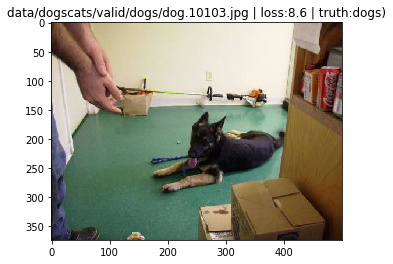

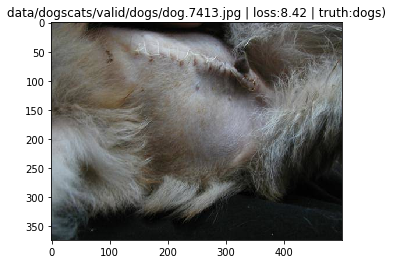

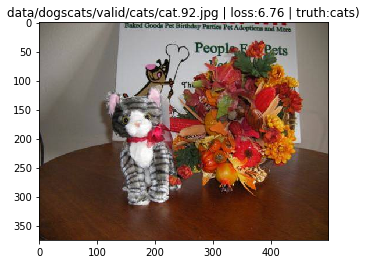

In [3]:
learner.view_top_losses(n=3, preproc=preproc)

The third most misclassified image (i.e., *cat.92.jpg*) is interesting in that there are no real dogs or cats in the picture.  Nevertheless, the image has a ground truth label of **cats**.  Perhaps this is because there is a stuffed cat in the photo.  There is, however, also a cartoon dog in the background.  

Our classifier is understandably confused and placed the picture in the **dogs** category.  (We know that because `view_top_losses` only displays incorrect classifications and the ground truth label is **cats**.)  But, **why** has our classifier predicted **dogs** for this photo?  Is it mistaking the stuffed cat for a dog or is it focusing on the cartoon dog in the background?  We can find the answer by creating a `Predictor` object and invoking the `explain` method.

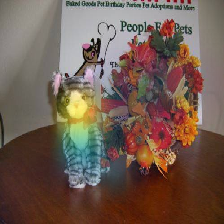

In [4]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.explain('/home/amaiya/data/dogscats/valid/cats/cat.92.jpg')

The `explain` method displays the image and highlights the area on which the classifier focuses to make the prediction.  It looks like the classifier is mistaking the stuffed cat for a dog, which is understandable given that there are no real dogs or cats in this photo.

Let us now turn our attention to the top most misclassified photo above that clearly depicts a real dog.  Why is our classifier getting this wrong?  Is it mistaking the dog for a cat because of its pointy cat-like ears?  Let's invoke `predictor.explain` again to see.

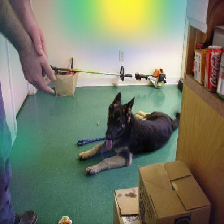

In [5]:
predictor.explain('/home/amaiya/data/dogscats/valid/dogs/dog.10103.jpg')

Suprisingly, it looks like the classifier is not even focusing on the dog when making the prediction!  This perhaps is an indication that we simply need to train for more epochs and minimize loss further to get the classifier to focus on the blurry dog. Indeed, when training for more epochs, this example is almost always classified correctly.

These visualizations are based on the [Grad-CAM technique](https://arxiv.org/abs/1610.02391) and is supported in *ktrain* via the [eli5](https://github.com/TeamHG-Memex/eli5) library.

## Explaining Text Classification

We can also visualize which words **text classifiers** tend to focus on when making predictions.  As before, let's use *ktrain* to quickly build a text classifier to classify [IMDb movie reivews](https://ai.stanford.edu/~amaas/data/sentiment/) as positive or negative.

In [8]:
# imports
import ktrain
from ktrain import text

# STEP 1: load and preprocess text data
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder('data/aclImdb', 
                                                                       max_features=20000, maxlen=400, 
                                                                       ngram_range=1, 
                                                                       train_test_names=['train', 'test'],
                                                                       classes=['pos', 'neg'])
                
# STEP 2: define a Keras text classification model
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
model = Sequential()
model.add(Embedding(20000+1, 50, input_length=400)) # add 1 for padding token
model.add(GlobalAveragePooling1D())
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test))

# STEP 3: train
learner.autofit(0.005, 2)

Word Counts: 88582
Nrows: 25000
25000 train sequences
Average train sequence length: 231
x_train shape: (25000,400)
y_train shape: (25000,2)
25000 test sequences
Average test sequence length: 224
x_test shape: (25000,400)
y_test shape: (25000,2)


begin training using triangular learning rate policy with max lr of 0.005...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 9s 357us/step - loss: 0.4417 - acc: 0.8027 - val_loss: 0.3042 - val_acc: 0.8802
Epoch 2/2
25000/25000 [==============================] - 8s 321us/step - loss: 0.2298 - acc: 0.9149 - val_loss: 0.2813 - val_acc: 0.8874


As we did above, we invoke `view_top_losses` to view the most misclassified review in the validation set.

In [9]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:8244 | loss:11.51 | truth:neg)

is not like mickey rourke ever really disappeared he has had a steady string of appearances before he burst back on the scene he was memorable in domino sin city man on fire once upon a time in mexico and get carter but in his powerful dramatic performance in the wrestler 2008 we see a full blown presentation of the character only hinted at in get carter whenever we get to know him rourke remains a cool but sleazy muscle bound slim ball br br this is an leonard story and production leonard wrote such notable movies as western thriller 3 10 to yuma be cool jackie brown get 52 pick up and joe this means that we get tough guys some good some not so good br br it also means we get tight realistic plots with characters doing what is best for them in each situation weaving complications into violent conclusions is no different tough slim ball killer rourke stalks unhappily married witness lane think history of violence meets no country for old me

The review is evidently about a movie starring Mickey Rourke, but it is difficult to follow. This is partly because the text displayed is post-processed in that punctuation and rare words are omitted (including the actual title of the movie!).  Let's use the ID of this document (i.e., id=8244 as shown above) to retrieve the original text and supply that as input to `predictor.explain`.

In [10]:
from sklearn.datasets import load_files
test_b = load_files(os.path.join('data/aclImdb',  'test'), shuffle=False, categories=['neg', 'pos'])
doc = test_b.data[8244].decode('utf-8')

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [12]:
predictor.explain(doc)

The visualization is generated using a technique called [LIME](https://arxiv.org/abs/1602.04938).  The input is randomly perturbed to examine how the prediction changes.  This is used to infer the relative importance of different words to the final prediction using a linear interpretable model.  The GREEN words contribute to the incorrect classification. The RED (and PINK) words detract from our final prediction. (Shade of color denotes the strength or size of the coefficients in the inferred linear model.)   By examining the GREEN words, we can see that the review is overall positive despite being given a ground truth label of negative.  In fact, the last line recommends this movie as a rental. The review is also odd in that it spends a lot of time praising past performances of the actors in previous movies. The PINK words show us that there is not very much there in terms of negative words that would lead us to conclude that this is a negative review.  For these reasons, we can probably forgive our simple model for misclassifying this particular review as positive, as many humans would probably classify this as positive, as well.